# PART 2: FAKE NEWS DETECTION

# Importing packages

In [39]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

import re
import spacy
import string

import warnings
warnings.filterwarnings("ignore")

#Language Detection
!pip install langdetect

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

#deep learning library
from keras.models import *
from keras.layers import *
from keras.callbacks import *

from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf

# DATA

In [2]:
df_true = pd.read_csv('True.csv')
df_fake = pd.read_csv('Fake.csv')

print("True News Dataframe's length is " + str(len(df_true)))
print("Fake News Dataframe's length is " + str(len(df_fake)))

True News Dataframe's length is 21417
Fake News Dataframe's length is 23481


### Language Detection & Insight

In [3]:
from langdetect import detect
df_true['lang'] = None
for i in range(len(df_true['text'])):
    try: 
        df_true['lang'][i] = detect(df_true['text'][i])   
    except:
        pass

In [4]:
df_fake['lang'] = None
for i in range(len(df_fake['text'])):
    try:
        df_fake['lang'][i] = detect(df_fake['text'][i])
    except:
        pass

In [5]:
df_true['lang'].unique()

array(['en', None], dtype=object)

In [6]:
df_fake['lang'].unique()

array(['en', None, 'fi', 'es', 'de', 'pt', 'sw', 'id', 'pl', 'so', 'ro',
       'vi', 'fr'], dtype=object)

In [7]:
non_en = df_fake[df_fake['lang'].isin(['fi', 'de', 'pt', 'sw', 'fr', 'pl', 'so', 'ro', 'vi','es',None])]

In [8]:
non_en.tail(10)

,title,text,subject,date,lang
21787,(VIDEO) PAM GELLER HAMMERS CNN HOST: “Did Christians Burn Embassies When Jesus Christ Was Put in Jar of Urine?”,,left-news,"May 4, 2015",None
21813,(VIDEO) MOM OF THE YEAR! WHEN YOUR MOM CATCHES YOU RIOTING AND BEATS YOUR A@@ ON LIVE TV,,left-news,"Apr 27, 2015",None
21815,(VIDEO) RIOTERS TAKE SELFIES WITH TORCHED POLICE CAR,,left-news,"Apr 27, 2015",None
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN NATIONAL GUARD AND DECLARES A STATE OF EMERGENCY,,left-news,"Apr 27, 2015",None
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO CLINTON CASH,,left-news,"Apr 25, 2015",None
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUST BE CHANGED TO ACCOMMODATE ABORTION,,left-news,"Apr 25, 2015",None
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAMES OF CRIMINAL ILLEGALS RELEASED INTO AMERICA,,left-news,"Apr 14, 2015",None
21869,https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg,https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg,left-news,https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg,None
21870,https://fedup.wpengine.com/wp-content/uploads/2015/04/entitled.jpg,https://fedup.wpengine.com/wp-content/uploads/2015/04/entitled.jpg,left-news,https://fedup.wpengine.com/wp-content/uploads/2015/04/entitled.jpg,None
21873,"(VIDEO) HYSTERICAL SNL TAKE ON HILLARY’S ANNOUNCEMENT: ‘BUCKLE UP AMERICA, THE CLINTONS ARE BACK!’",,left-news,"Apr 12, 2015",None


In [9]:
len(df_fake[df_fake['title'].str.contains('VIDEO')])/len(df_fake)

0.2327413653592266

### Insight:
    - All True News are in English
    - Fake News contains a lot of http links and term [(VIDEOS)] (around 23%) in their content, so we will need to get rid of these to purify data
    - Fake News uses a lot of caplocks so we will need to lowercase data

### Merging Datasets

In [10]:
df_true['is_true'] = 1
df_fake['is_true'] = 0
df = pd.concat([df_fake,df_true],ignore_index=True)

# Exploratory Data Analysis

### Dataframe overall information

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   lang     44183 non-null  object
 5   is_true  44898 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 2.1+ MB


### Checking for imbalance class

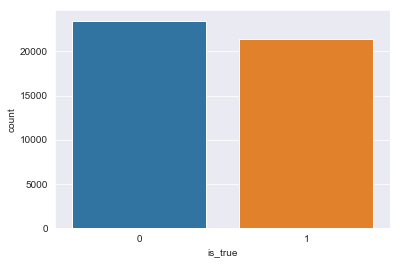

In [12]:
sns.set_style("darkgrid")
sns.countplot(x = df.is_true)

### Counting Catergory of True News and Fake News

In [13]:
df[df['is_true']==0].subject.value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

In [14]:
df[df['is_true']==1].subject.value_counts()

politicsNews    11272
worldnews       10145
Name: subject, dtype: int64

[Text(0,0,'News'),
 Text(0,0,'politics'),
 Text(0,0,'Government News'),
 Text(0,0,'left-news'),
 Text(0,0,'US_News'),
 Text(0,0,'Middle-east'),
 Text(0,0,'politicsNews'),
 Text(0,0,'worldnews')]

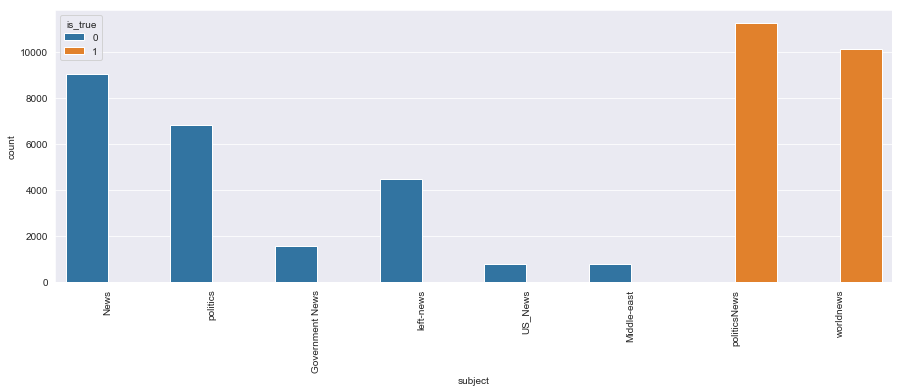

In [15]:
plt.figure(figsize = (15,5))
chart = sns.countplot(x = "subject", hue = "is_true" , data = df)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

### Merging title and text column into a column called "content"

```
The reason why only text columns - Title and Text are merged together excluding subject column is that. 
True_news has 2 category and Fake_new has 5 category:
None of them are overlapped. If they are merged and introduced into training data, it will cause leakage and bias.
```

In [16]:
df['text'] = df['text'] + " " + df['title']
del df['title']

# Data Cleaning

#### Cleaning Data by:
    - Convert to Lower case
    - Remove Specials
    - Remove Whitespace
    - Lemmatize Words
    - Remove Stopwords

In [17]:
lang_stopwords = stopwords.words('english')

In [18]:
def lower_case(text):
    words = nltk.word_tokenize(text)
    words = [w.lower() for w in words]
    return " ".join(words)  

def remove_http(text):
    return re.sub(r'http\S+', '', text)

def remove_specials(text):
    text = text.replace("[^a-zA-Z#]", " ")
    return re.sub(r'[^a-zA-Z0-9 ]',r'',text)

lemmatizer = WordNetLemmatizer() 
def lemmatize_words(text):
    words = nltk.word_tokenize(text)
    words = [lemmatizer.lemmatize(w, "v") for w in words]
    return " ".join(words)


def remove_stopwords(text):
    words = nltk.word_tokenize(text)
    stopwords_removed = [w for w in words if w.lower() not in lang_stopwords]
    return " ".join(stopwords_removed)

def remove_whitespace(text):
    return " ".join(text.split())

In [19]:
for i in range(len(df['text'])):
    df['text'][i] = lower_case (df['text'][i])
    df['text'][i] = remove_http (df['text'][i])
    df['text'][i] = remove_specials (df['text'][i])
    df['text'][i] = lemmatize_words (df['text'][i])
    df['text'][i] = remove_stopwords (df['text'][i])
    df['text'][i] = remove_whitespace (df['text'][i])

In [20]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(50,20))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

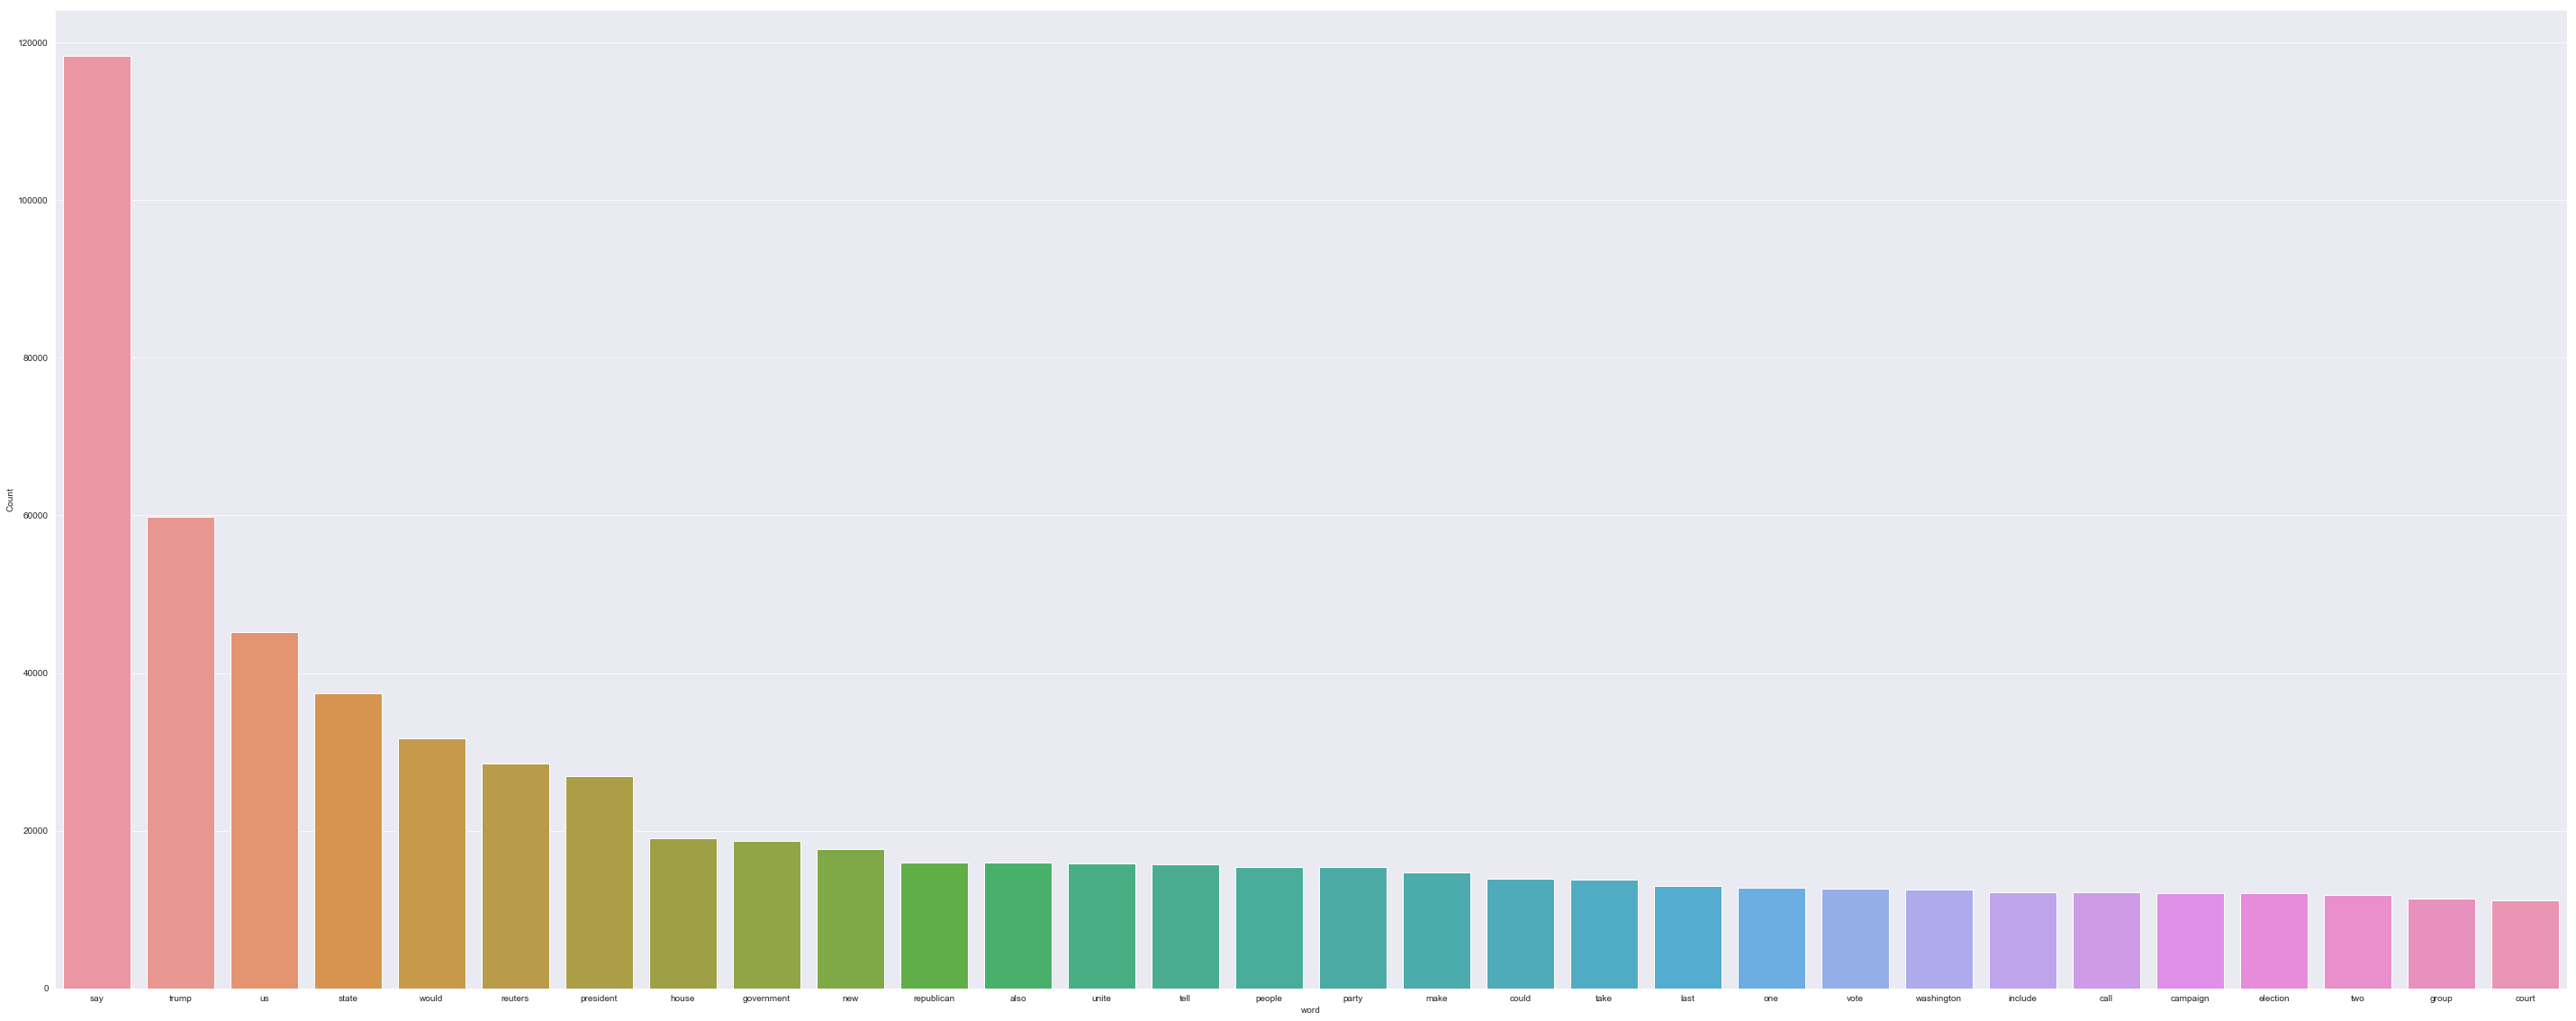

In [21]:
freq_words(df[df['is_true']==1]['text'])

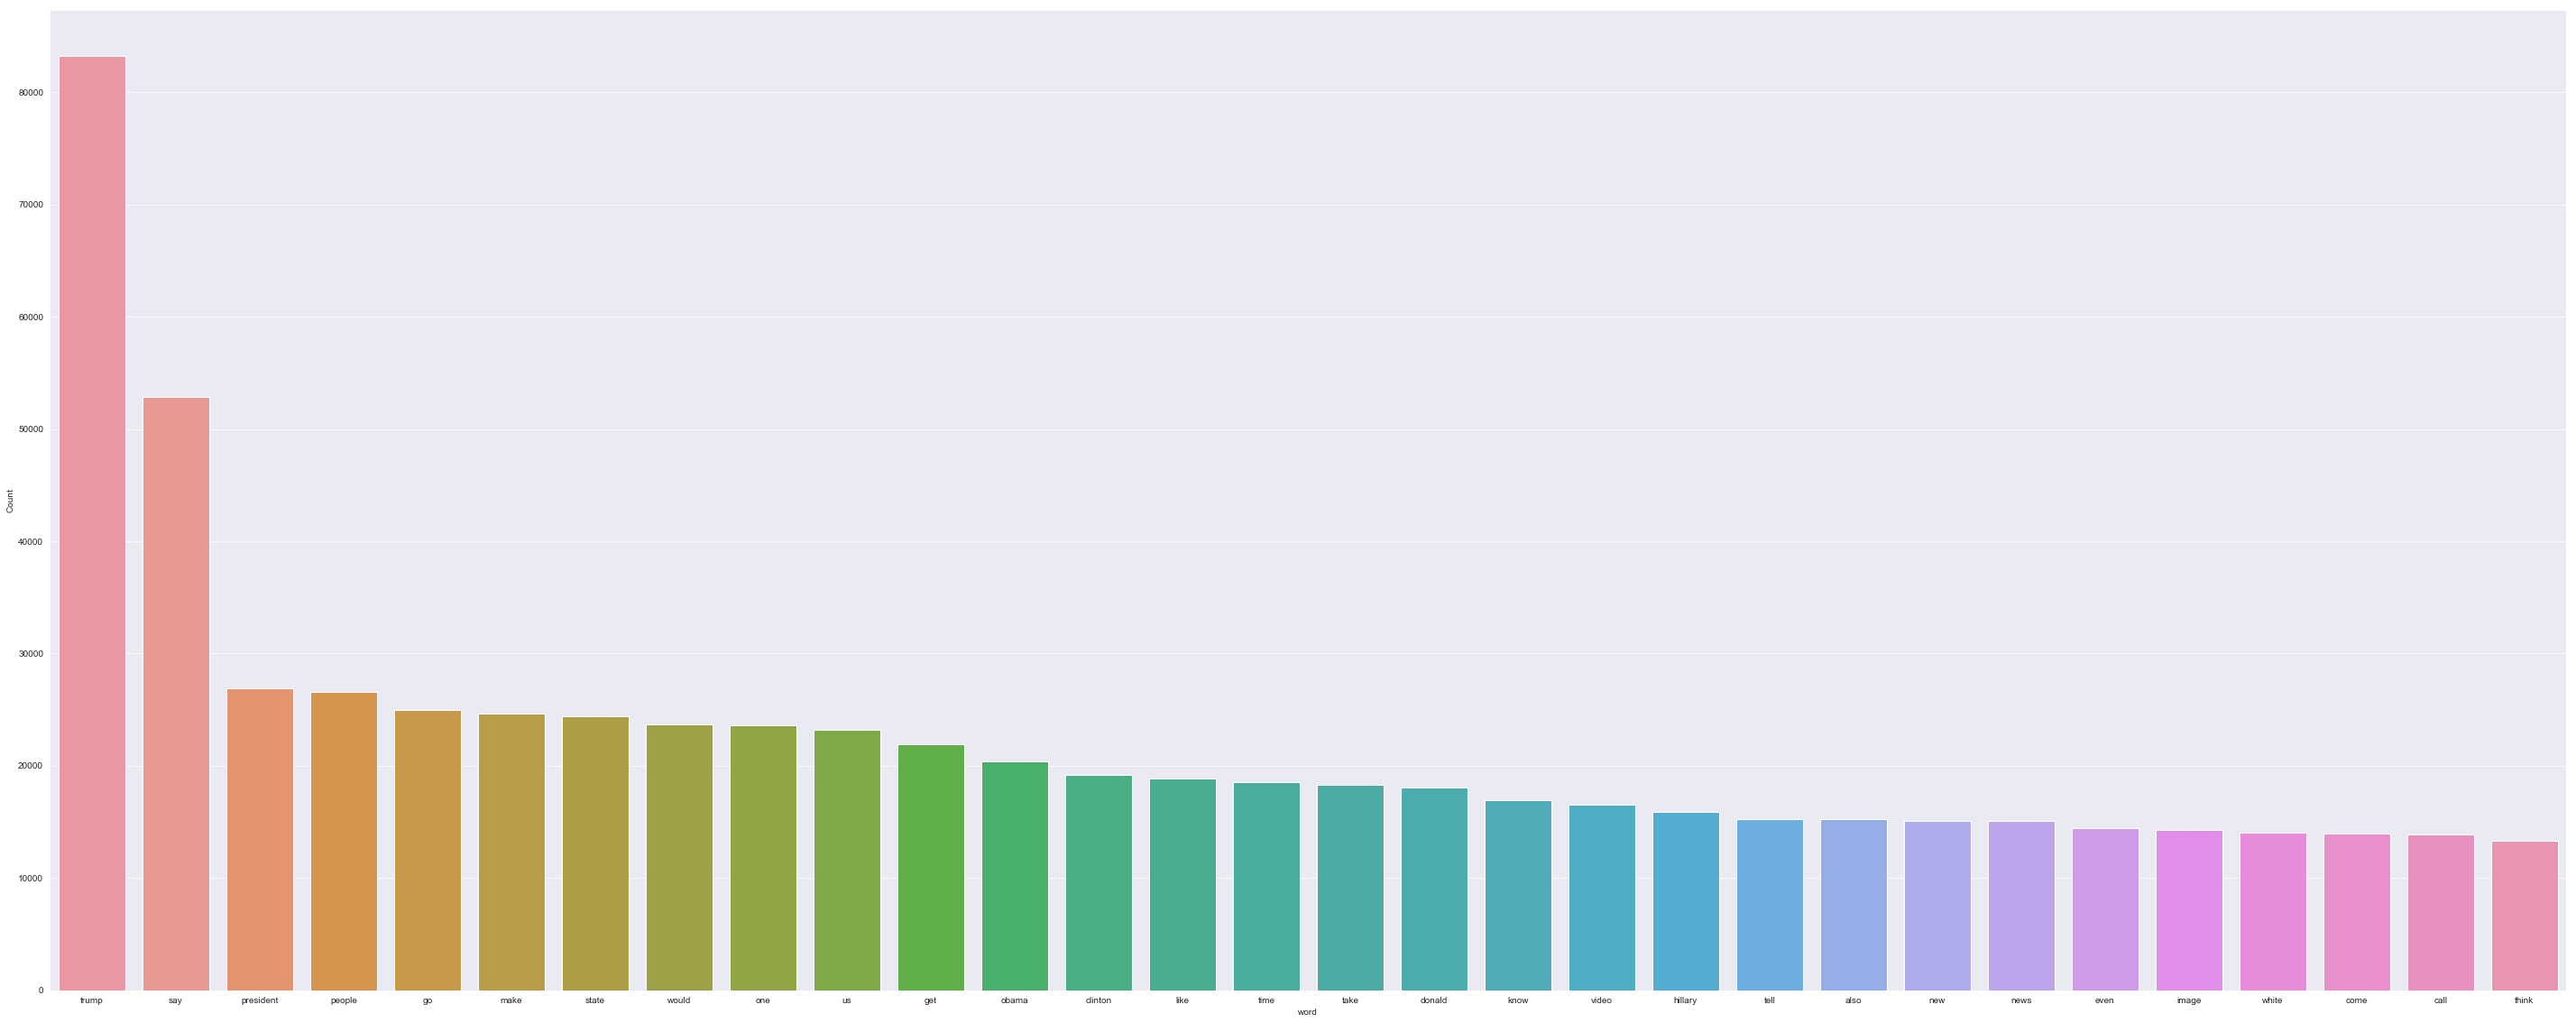

In [22]:
freq_words(df[df['is_true']==0]['text'])

In [23]:
### Delete Publication info in Real News
additional_stopwords = ['video','reuters']

def remove_additional(text):
    words = nltk.word_tokenize(text)
    stopwords_removed = [w for w in words if w not in additional_stopwords]
    return " ".join(stopwords_removed)

In [24]:
for i in range(len(df['text'])):
    df['text'][i] = remove_additional (df['text'][i])

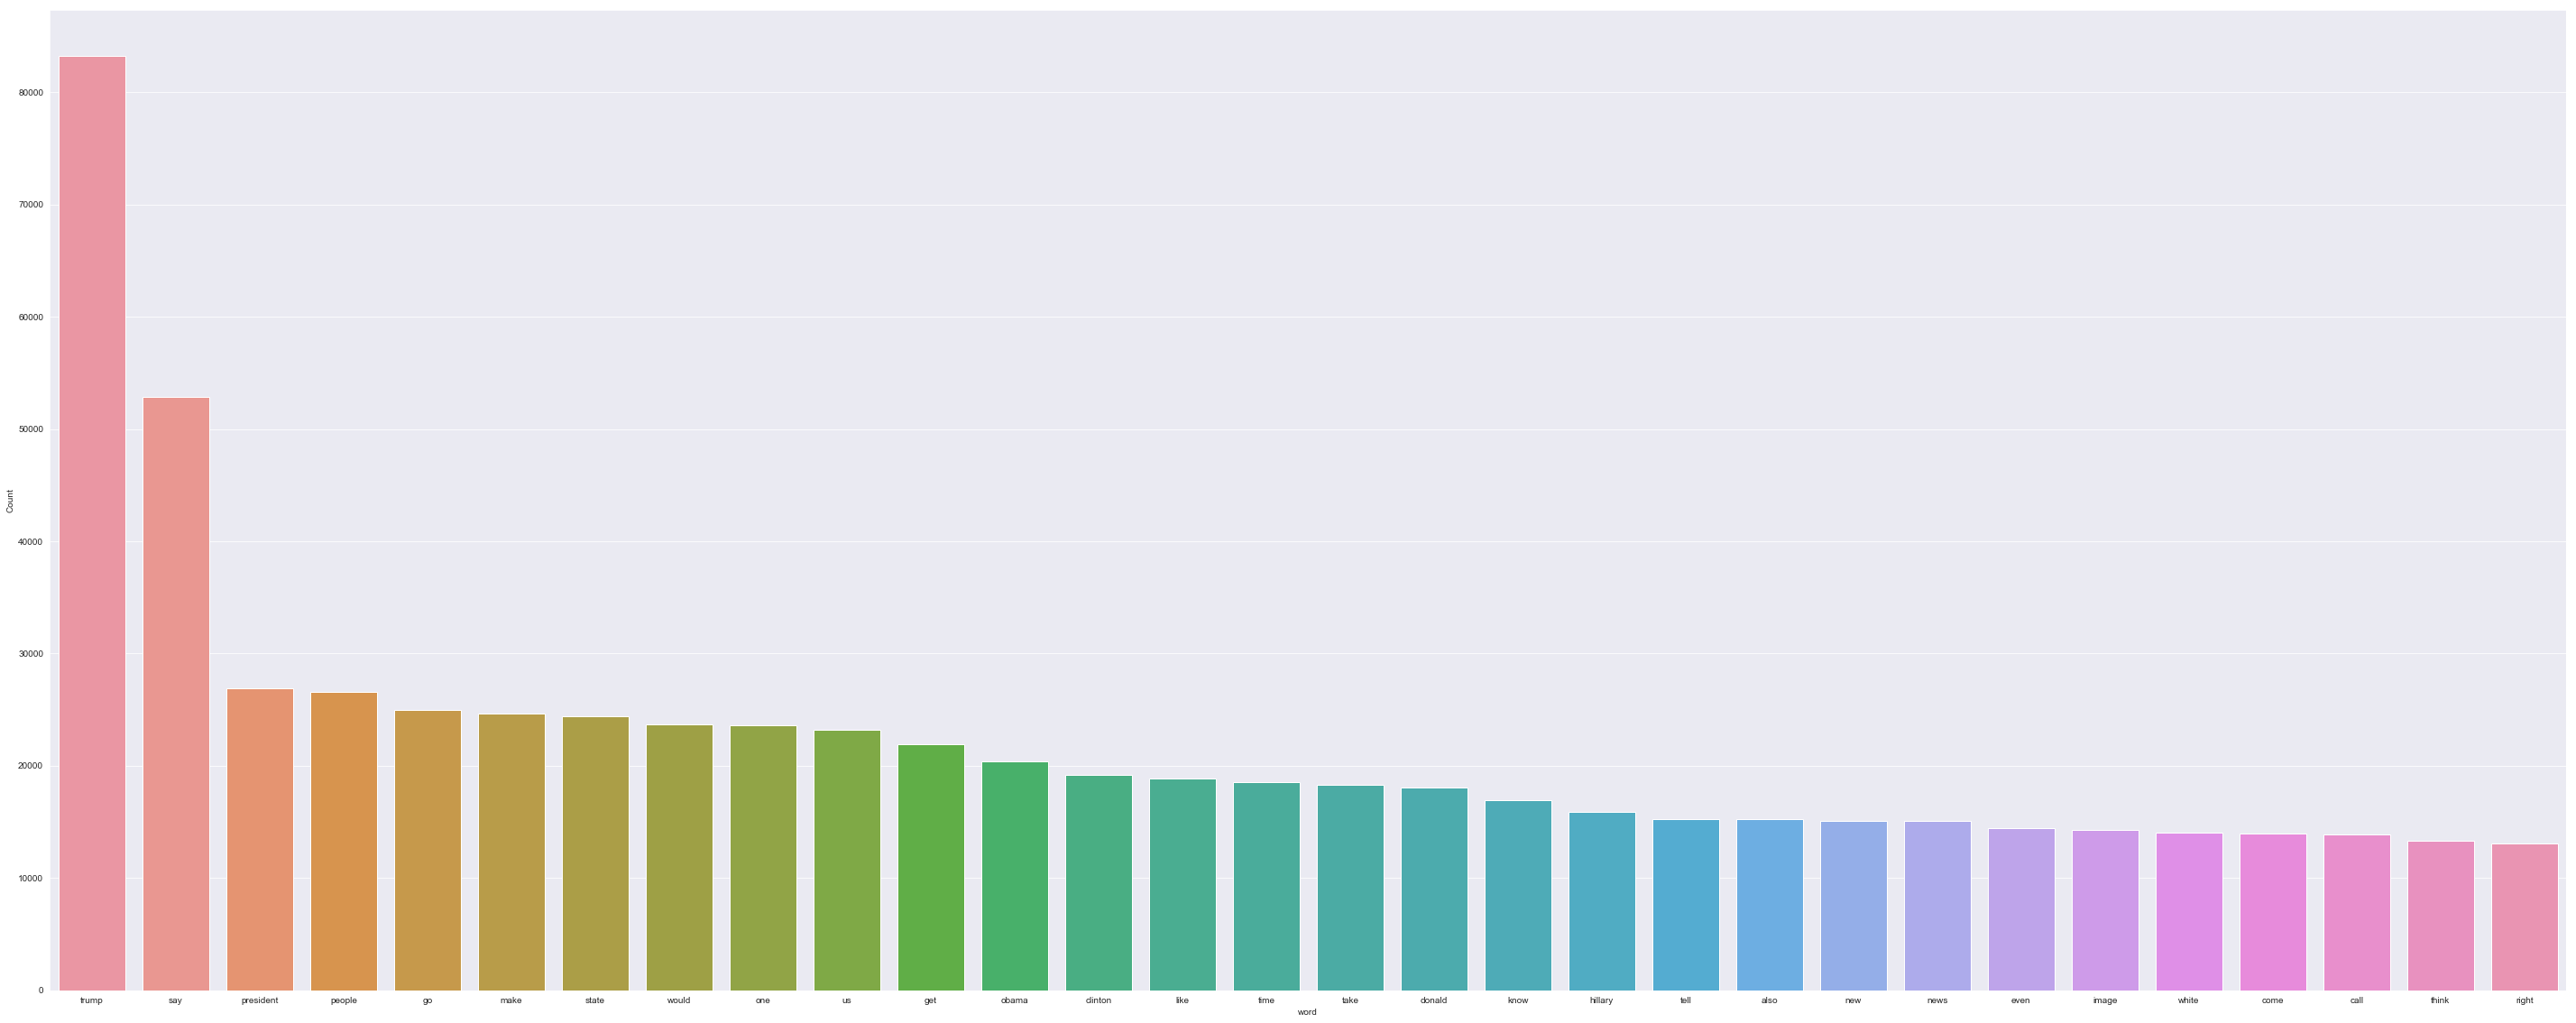

In [25]:
freq_words(df[df['is_true']==0]['text'])

### Top 20 words in News

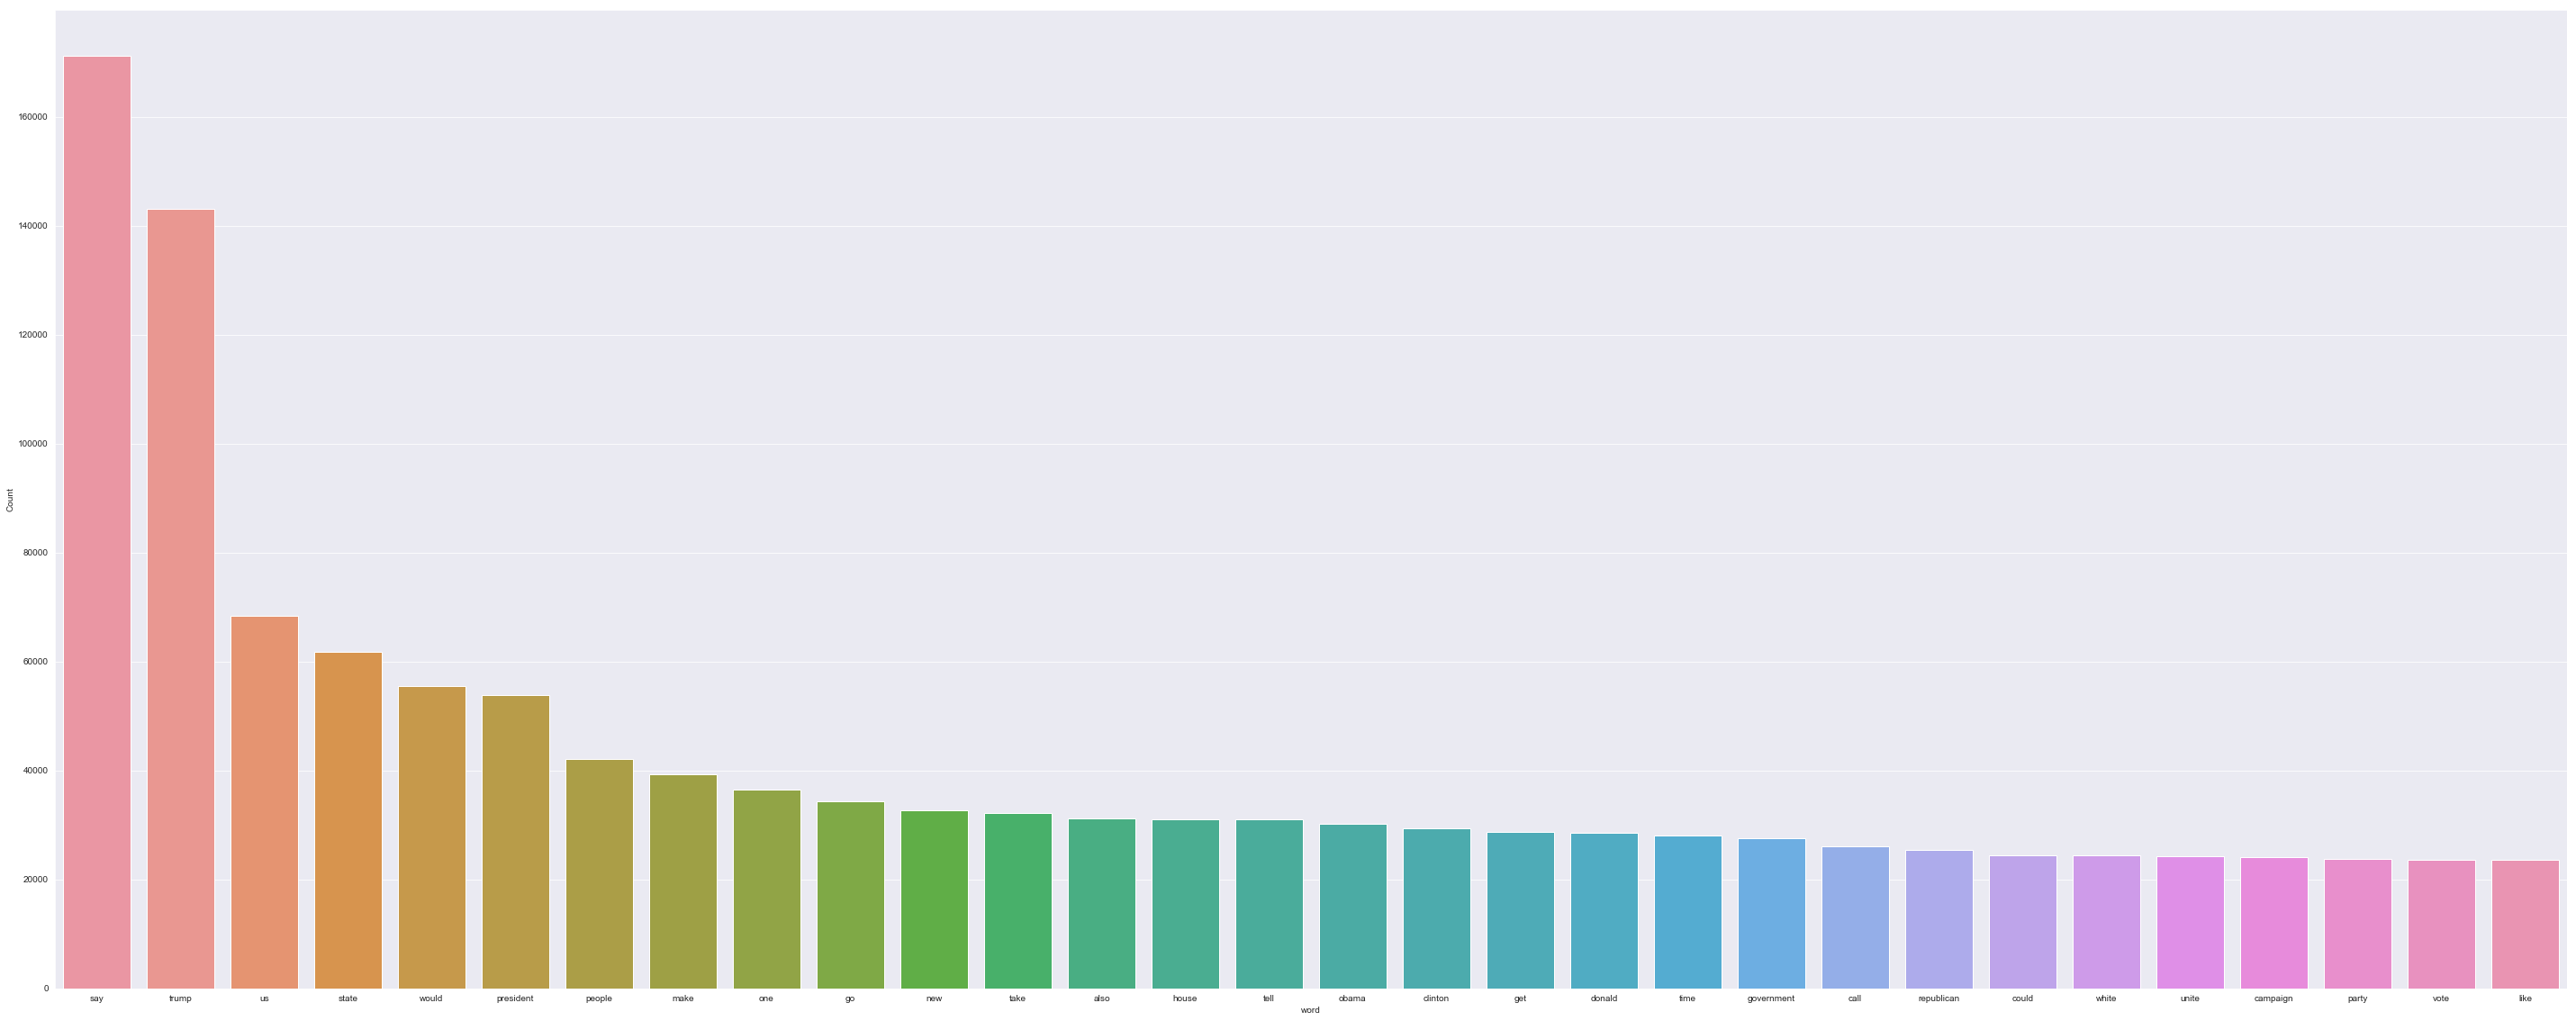

In [26]:
freq_words(df['text'])

# MODELS

## Creating Training Data and Testing Data¶

In [27]:
from sklearn.model_selection import train_test_split
X = df['text']
Y = df['is_true']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

## 1. LSTM with GloVe Embedding

In [28]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#Tokenize the sentences
tokenizer = Tokenizer()

#preparing vocabulary
tokenizer.fit_on_texts(list(X_train))

#converting text into integer sequences
x_tr_seq  = tokenizer.texts_to_sequences(X_train) 
x_val_seq = tokenizer.texts_to_sequences(X_test)

#padding to prepare sequences of same length
x_tr_seq  = pad_sequences(x_tr_seq, maxlen=100)
x_val_seq = pad_sequences(x_val_seq, maxlen=100)

size_of_vocabulary=len(tokenizer.word_index) + 1 #+1 for padding
print(size_of_vocabulary)

168693


### Word Embedding

In [29]:
#Source Code: https://www.analyticsvidhya.com/blog/2020/03/pretrained-word-embeddings-nlp/

embeddings_index = dict()
f = open('glove.6B.300d.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

embedding_matrix = np.zeros((size_of_vocabulary, 300))

Loaded 400000 word vectors.


In [30]:
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### LSTM

In [31]:
model=Sequential()

#embedding layer
model.add(Embedding(size_of_vocabulary,300,weights=[embedding_matrix],input_length=100,trainable=False)) 

#lstm layer
model.add(LSTM(128,return_sequences=True,dropout=0.2))

#Global Maxpooling
model.add(GlobalMaxPooling1D())

#Dense Layer
model.add(Dense(64,activation='relu')) 
model.add(Dense(1,activation='sigmoid')) 

#Add loss function, metrics, optimizer
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=["acc"]) 

#Adding callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)  
mc=ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', save_best_only=True,verbose=1)  

#Print summary of model
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          50607900  
_________________________________________________________________
lstm (LSTM)                  (None, 100, 128)          219648    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 50,835,869
Trainable params: 227,969
Non-trainable params: 50,607,900
_________________________________________________________________
None


In [32]:
history = model.fit(np.array(x_tr_seq),np.array(y_train),batch_size=128,epochs=10,
                    validation_data=(np.array(x_val_seq),np.array(y_test)),verbose=1,
                    callbacks=[es,mc])

Epoch 1/10
246/246 [==============================] - 58s 231ms/step - loss: 0.3031 - acc: 0.8763 - val_loss: 0.1071 - val_acc: 0.9576

Epoch 00001: val_acc improved from -inf to 0.95761, saving model to best_model.h5
Epoch 2/10
246/246 [==============================] - 56s 227ms/step - loss: 0.0961 - acc: 0.9633 - val_loss: 0.0688 - val_acc: 0.9756

Epoch 00002: val_acc improved from 0.95761 to 0.97565, saving model to best_model.h5
Epoch 3/10
246/246 [==============================] - 58s 238ms/step - loss: 0.0520 - acc: 0.9826 - val_loss: 0.0545 - val_acc: 0.9808

Epoch 00003: val_acc improved from 0.97565 to 0.98077, saving model to best_model.h5
Epoch 4/10
246/246 [==============================] - 64s 261ms/step - loss: 0.0325 - acc: 0.9895 - val_loss: 0.0464 - val_acc: 0.9842

Epoch 00004: val_acc improved from 0.98077 to 0.98419, saving model to best_model.h5
Epoch 5/10
246/246 [==============================] - 65s 266ms/step - loss: 0.0203 - acc: 0.9935 - val_loss: 0.0429 - 

In [48]:
#loading best model
from keras.models import load_model
model = load_model('best_model.h5')

y_pred = model.predict_classes(x_val_seq)


_,val_acc = model.evaluate(x_val_seq,y_test, batch_size=128)
print(val_acc)

from sklearn.metrics import classification_report
# Creating classification report 
print(classification_report(y_test, y_pred, target_names = ['Fake','Not Fake']))

106/106 [==============================] - 9s 83ms/step - loss: 0.0444 - acc: 0.9869
0.9869339466094971
              precision    recall  f1-score   support

        Fake       0.99      0.98      0.99      7091
    Not Fake       0.98      0.99      0.99      6379

    accuracy                           0.99     13470
   macro avg       0.99      0.99      0.99     13470
weighted avg       0.99      0.99      0.99     13470



## 2. XGBoost with TF-DIF

In [34]:
#Fitting on Train Data only
tfidf = TfidfVectorizer()
tfidf.fit(X_train)

X_train_xgb = tfidf.transform(X_train)
X_test_xgb = tfidf.transform(X_test)

In [35]:
#function for easy training and valuation
#source: https://www.kaggle.com/sakana/classification-with-tf-idf-and-lightgbm
from sklearn.metrics import classification_report,roc_auc_score
def train_and_predict(clf):
    clf.fit(X_train_xgb, y_train)
    y_pred = clf.predict(X_test_xgb)
    auc_score = roc_auc_score(y_test, y_pred)
    print('auc: {:.5}'.format(auc_score))
    print(classification_report(y_test, y_pred, target_names = ['Fake','Not Fake']))
    return clf, y_pred

In [36]:
from xgboost import XGBClassifier
clf = XGBClassifier(eval_metric='rmse', use_label_encoder=False)
train_and_predict(clf)

auc: 0.98805
              precision    recall  f1-score   support

        Fake       0.99      0.99      0.99      7091
    Not Fake       0.99      0.99      0.99      6379

    accuracy                           0.99     13470
   macro avg       0.99      0.99      0.99     13470
weighted avg       0.99      0.99      0.99     13470



(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
               gamma=0, gpu_id=-1, importance_type='gain',
               interaction_constraints='', learning_rate=0.300000012,
               max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
               monotone_constraints='()', n_estimators=100, n_jobs=8,
               num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
               scale_pos_weight=1, subsample=1, tree_method='exact',
               use_label_encoder=False, validate_parameters=1, verbosity=None),
 array([0, 1, 1, ..., 1, 0, 1]))

### 3. BiLSTMs

In [42]:
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X, Y, test_size=0.30, random_state=42)

In [43]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train_rnn)

# tokenize the text into vectors 
X_train_rnn = tokenizer.texts_to_sequences(X_train_rnn)
X_test_rnn = tokenizer.texts_to_sequences(X_test_rnn)

X_train_rnn = tf.keras.preprocessing.sequence.pad_sequences(X_train_rnn, padding='post', maxlen=256)
X_test_rnn = tf.keras.preprocessing.sequence.pad_sequences(X_test_rnn, padding='post', maxlen=256)

In [45]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 32),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train_rnn, y_train_rnn, epochs=5,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/5
943/943 [==============================] - 229s 238ms/step - loss: 0.4693 - accuracy: 0.7057 - val_loss: 0.0903 - val_accuracy: 0.9755
Epoch 2/5
943/943 [==============================] - 234s 248ms/step - loss: 0.0673 - accuracy: 0.9833 - val_loss: 0.0599 - val_accuracy: 0.9809
Epoch 3/5
943/943 [==============================] - 224s 237ms/step - loss: 0.0304 - accuracy: 0.9932 - val_loss: 0.0581 - val_accuracy: 0.9828
Epoch 4/5
943/943 [==============================] - 224s 238ms/step - loss: 0.0295 - accuracy: 0.9941 - val_loss: 0.0566 - val_accuracy: 0.9831
Epoch 5/5
943/943 [==============================] - 224s 237ms/step - loss: 0.0148 - accuracy: 0.9971 - val_loss: 0.0555 - val_accuracy: 0.9870


In [46]:
y_pred_rnn = model.predict_classes(X_test_rnn)

#evaluation 
_,val_acc = model.evaluate(X_test_rnn,y_test_rnn, batch_size=128)
print(val_acc)

print(classification_report(y_test_rnn, y_pred_rnn, target_names = ['Fake','Not Fake']))

106/106 [==============================] - 18s 166ms/step - loss: 0.0571 - accuracy: 0.9880
0.9879732728004456
              precision    recall  f1-score   support

        Fake       0.99      0.99      0.99      7091
    Not Fake       0.99      0.99      0.99      6379

    accuracy                           0.99     13470
   macro avg       0.99      0.99      0.99     13470
weighted avg       0.99      0.99      0.99     13470



# Summary

- My inital idea is to break-down the project into pipeline:
    Data Loading => Data Preprocessing => Word Embedding => Model

- Under Model phase, there are 2 branches, which are traditional machine learning models and deep learning models.
Since the requirement is to implement 3 models, I decided to choose 1 from machine learning and 2 from deep learning branch.

    - For Machine Learning Model, XGBoost is chosen due to its nature of ensemble learning and proven perefomance it numerous tasks
    - For deep learning models, I chose LSTM and BiLSTMs (based on literature research, they are known to generate good result for text classifcation tasks). LSTM only keep track of information of the past while BiLSTMs looks both way. So the end goal here is to test to see which method works better for fake news detection (end result: BiLSTMs is better than LSTM)


- Under Word Embedding Phase, there are a number of options such as Word2Vec (CBOW or Skipgram),TF-IDF, Fasttext, GloVe, XLNET, RoBERTa...
        => Here I chose TF-IDF (a traditional approach) and GloVe Word Embedding

3 Model chosen with exact accuracy lelel:
- LSTM with GloVe  = 0.9869
- XGBosst with TF-IDF = 0.9880
- BiLSTMs = 0.9880

f1 Score of all three aproaches are almost equivalently high but XGBoost run significantly faster than NN models. In the context of this particular dataset, I would go with XGBoost who generated same accuracy as BiLSTMs with faster time.

Reference: https://towardsdatascience.com/model-selection-in-text-classification-ac13eedf6146